In [1]:
#imports
import os
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import enlighten

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

#RDKit related imports
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Draw
from rdkit import DataStructs

#scikit imports
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



#tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

RDLogger.logger().setLevel(RDLogger.CRITICAL)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/home/nathaniel/anaconda3/envs/assay_ML/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from datetime import datetime
import glob

In [3]:
now = datetime.now()

dform = now.strftime('%y%m%d')

In [4]:
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [5]:
cols = pd.read_csv('backup_df.csv', nrows=1).columns
dataframe = pd.read_csv('backup_df.csv', index_col=False, usecols=cols[1:])

In [ ]:
PandasTools.AddMoleculeColumnToFrame(dataframe, 'PUBCHEM_CANONICAL_SMILES', 'ROMol', includeFingerprints=True)

In [8]:
RF_dataset = dataframe.copy()

In [9]:
PandasTools.RemoveSaltsFromFrame(RF_dataset)

In [10]:
RF_dataset['Active'] = np.NaN

In [11]:
for index, row in RF_dataset.iterrows():
    activity = row.PUBCHEM_ACTIVITY_OUTCOME
    if activity == 'Active':
        RF_dataset.loc[index, 'Active'] = 1
    else:
        RF_dataset.loc[index, 'Active'] = 0

In [12]:
RF_dataset['Active'] = RF_dataset['Active'].astype(int)

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_CANONICAL_SMILES,ROMol,Active
0,1511,56314828,1988,Inactive,0,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,0
1,1511,56321651,425322,Inactive,0,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,0
2,1511,56322145,24981957,Inactive,0,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,0

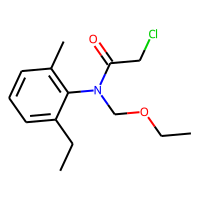
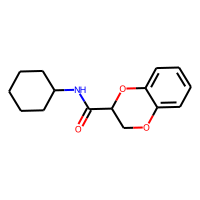
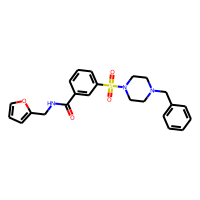

In [13]:
show(RF_dataset.head(3))

In [14]:
#get fingerprints etc
activity_binary = []
ECFP6s = []
topols = []
atom_pairs = []



pbar = enlighten.Counter(total=len(RF_dataset.index), desc='Calculating molecular descriptors', unit='ticks')

for ID, row in RF_dataset.iterrows():
    # print(i)

    mol = row.ROMol# if i == max_radius else row[f'FRAG_R{i}']          

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)

    ECFP6s.append(ECFP6_vec)
    topols.append(topol_vec)
    atom_pairs.append(atpair_vec)



    # print(descriptor)
    activity_binary.append(row.PUBCHEM_ACTIVITY_OUTCOME)
    pbar.update()


In [15]:
length = len(ECFP6s)

if all(len(lst) == length for lst in [ECFP6s, topols, atom_pairs]):
    print('Lists are equal in length')
else:
    print('Lists are unequal in length')

Lists are equal in length


In [16]:
#convert to numpy
ECFP6s_np = []
topols_np = []
atom_pairs_np = []

for i in range(len(ECFP6s)):
    ecfp_arr = np.zeros((1,))
    topol_arr = np.zeros((1,))
    atpair_arr = np.zeros((1,))


    ecfp = ECFP6s[i]
    topol = topols[i]
    atompair = atom_pairs[i]

    DataStructs.ConvertToNumpyArray(ecfp, ecfp_arr)
    DataStructs.ConvertToNumpyArray(topol, topol_arr)
    DataStructs.ConvertToNumpyArray(atompair, atpair_arr)

    ECFP6s_np.append(ecfp_arr)
    topols_np.append(topol_arr)
    atom_pairs_np.append(atpair_arr)


In [17]:
x_ecfp6 = ECFP6s_np
x_topols = topols_np
x_atpairs = atom_pairs_np

In [18]:
y = RF_dataset.Active

In [19]:
y.shape

(305679,)

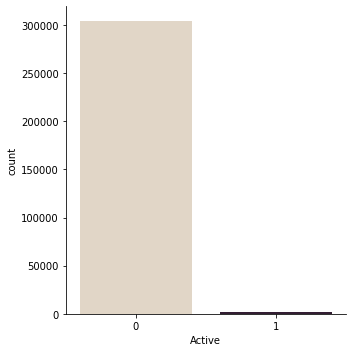

In [20]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

count_acts = sns.catplot(x='Active', kind="count", palette="ch:.25", data=RF_dataset)

In [22]:
# #Oversampling with ADASYN

# x_ecfp6_ada, y_ecfp6_ada = ADASYN().fit_resample(x_ecfp6, y)
# ecfp6_sample_count = sorted(Counter(y_ecfp6_ada).items())


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.models
import tensorflow as tf

In [24]:
# y_ten = tf.constant(y)

In [25]:
ecfp_ten = tf.constant(ECFP6s_np)


2022-09-09 15:00:05.362701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.440631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.440766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:00:05.442116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
#normaliser?
#probably not usable for fingerprints
#
# normaliser = Normalization(axis=-1)
# normaliser.adapt(x_ecfp6)
# normaliser.mean.numpy()

In [7]:
h = History()
red_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001, min_delta=1e-5)

In [8]:
#TF binary classification

def create_model(inp):

    optimiser = Adam(learning_rate=0.0005)
    model = Sequential()
    # model.add(normaliser)
    model.add(Dense(60, input_shape=(inp.shape[1],), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(60, input_shape=(inp.shape[1],), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))


    model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

In [29]:
ecfp6_mod = create_model(ecfp_ten)


In [30]:
ecfp6_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                122940    
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 126,661
Trainable params: 126,661
Non-trainable params: 0
_________________________________________________________________


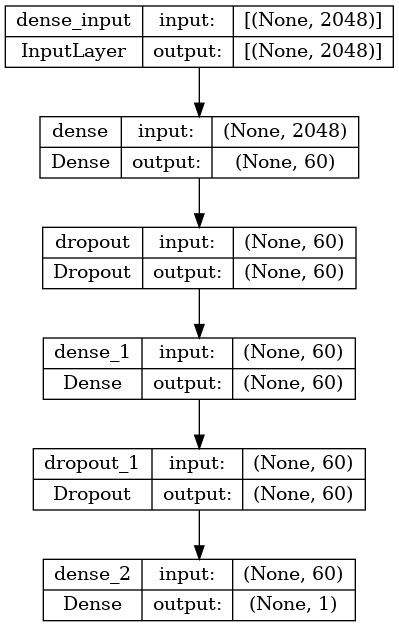

In [31]:
image_model = tf.keras.utils.plot_model(ecfp6_mod, "RNN_de_novo_generator.png", show_shapes=True)
display(Image(filename="RNN_de_novo_generator.png"))

In [32]:
ecfp6_mod.fit(
    x=ecfp_ten,
    y=y,
    epochs=200,
    verbose='auto',
    callbacks = [h, red_LR],
    validation_split=0.2,
)

2022-09-09 15:00:27.890325: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4006592512 exceeds 10% of free system memory.


Epoch 1/200
 123/7642 [..............................] - ETA: 9s - loss: 0.0573 - binary_accuracy: 0.9931  

2022-09-09 15:00:30.406096: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7642/7642 [==============================] - 12s 1ms/step - loss: 0.0364 - binary_accuracy: 0.9947 - val_loss: 0.0299 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 2/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0298 - binary_accuracy: 0.9949 - val_loss: 0.0273 - val_binary_accuracy: 0.9955 - lr: 0.0050
Epoch 3/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0281 - binary_accuracy: 0.9952 - val_loss: 0.0280 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 4/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0273 - binary_accuracy: 0.9955 - val_loss: 0.0324 - val_binary_accuracy: 0.9956 - lr: 0.0050
Epoch 5/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0246 - binary_accuracy: 0.9957 - val_loss: 0.0279 - val_binary_accuracy: 0.9957 - lr: 0.0050
Epoch 6/200
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0237 - binary_accuracy: 0.9959 - val_loss: 0.0288 - val_binary_accu

In [19]:
model_dir = os.path.join(os.getcwd(), 'models')

try:
    os.mkdir(model_dir)
except FileExistsError:
    print("Directory exists")

Directory exists


In [ ]:
ecfp6mod_name = os.path.join(model_dir, f'BASE_ecfp6_model')
ecfp6_mod.save(ecfp6mod_name)

In [7]:
ada_x_mmap = np.load('./adasyn/x_ecfpada.npy', mmap_mode='r')
ada_y_mmap = np.load('./adasyn/y_ecfpada.npy', mmap_mode='r')


In [8]:
ada_df = pd.DataFrame(data=ada_y_mmap, columns=['Active'])

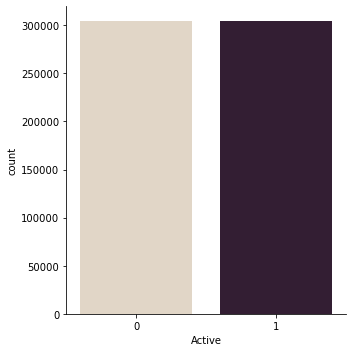

In [10]:
count_acts = sns.catplot(x='Active', kind="count", palette="ch:.25", data=ada_df)

In [20]:
assert not np.any(np.isnan(ada_x_mmap))

In [9]:
from custom_generator import data_generator

In [22]:
ada_x_train, ada_x_test, ada_y_train, ada_y_test = train_test_split(ada_x_mmap, ada_y_mmap)

In [10]:
batch_size = 2000
epochs = 300
# dim = ada_x_mmap.shape[1]

In [24]:
# training_generator = data_generator(ada_x_mmap, ada_y_mmap, dim, batch_size)

training_generator = data_generator(ada_x_train, ada_y_train, batch_size)
test_generator = data_generator(ada_x_test, ada_y_test, batch_size)

In [25]:
ADA_ecfp6_mod = create_model(ada_x_mmap)

In [26]:
ADA_ecfp6_mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 60)                122940    
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_4 (Dense)             (None, 60)                3660      
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                                 
Total params: 126,661
Trainable params: 126,661
Non-trainable params: 0
_________________________________________________________________


In [27]:
ADA_ecfp6_mod.fit(
    training_generator,
    validation_data=test_generator,
    use_multiprocessing=True,
    workers=6,
    epochs=epochs,
    verbose='auto',
    callbacks=[h,red_LR],
)

Epoch 1/300
229/229 [==============================] - 11s 44ms/step - loss: 0.3153 - binary_accuracy: 0.8647 - val_loss: 0.0908 - val_binary_accuracy: 0.9772 - lr: 5.0000e-04
Epoch 2/300
229/229 [==============================] - 11s 46ms/step - loss: 0.0576 - binary_accuracy: 0.9857 - val_loss: 0.0168 - val_binary_accuracy: 0.9964 - lr: 5.0000e-04
Epoch 3/300
229/229 [==============================] - 14s 58ms/step - loss: 0.0183 - binary_accuracy: 0.9961 - val_loss: 0.0070 - val_binary_accuracy: 0.9985 - lr: 5.0000e-04
Epoch 4/300
229/229 [==============================] - 11s 46ms/step - loss: 0.0093 - binary_accuracy: 0.9980 - val_loss: 0.0042 - val_binary_accuracy: 0.9990 - lr: 5.0000e-04
Epoch 5/300
229/229 [==============================] - 11s 46ms/step - loss: 0.0055 - binary_accuracy: 0.9989 - val_loss: 0.0031 - val_binary_accuracy: 0.9993 - lr: 5.0000e-04
Epoch 6/300
229/229 [==============================] - 11s 45ms/step - loss: 0.0039 - binary_accuracy: 0.9992 - val_loss

In [40]:
ADA_ecfp6mod_name = os.path.join(model_dir, f'ADA_ecfp6_model')
ADA_ecfp6_mod.save(ADA_ecfp6mod_name)

INFO:tensorflow:Assets written to: /home/nathaniel/Desktop/ASSAY_ML_BASE/tree_1/assay_ML/ML_RF_TensorFlow/models/ADA_ecfp6_model/assets


In [11]:
dirs = ['AT_PAIRS', 'ECFP', 'TOPOL']

In [12]:
curr_path = './adasyn/220915_out/'

In [13]:
ADA_files = []

for j in dirs:


    full_path = os.path.join(curr_path, j)

    x = glob.glob(os.path.join(full_path, 'x*'))
    y = glob.glob(os.path.join(full_path, 'y*'))

    x_file = np.load(x[0], mmap_mode='r')
    y_file = np.load(y[0], mmap_mode='r')


    tpl = (x_file, y_file)
    ADA_files.append(tpl)

    

In [14]:
#other models

ADA_data_gens = []

for i in ADA_files:
    x_train, x_test, y_train, y_test = train_test_split(i[0], i[1])

    train_gen = data_generator(x_train, y_train, batch_size)
    test_gen = data_generator(x_test, y_test, batch_size)

    

    tpl = (train_gen, test_gen)
    ADA_data_gens.append(tpl)



# training_generator = data_generator(ada_x_train, ada_y_train, batch_size)
# test_generator = data_generator(ada_x_test, ada_y_test, batch_size)

In [15]:
dirs

['AT_PAIRS', 'ECFP', 'TOPOL']

In [16]:
ADA_ATPAIR_mod = create_model(ADA_files[0][0])
ADA_TOPOL_mod = create_model(ADA_files[2][0])

2022-09-16 15:39:39.225923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 15:39:39.319708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 15:39:39.319856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 15:39:39.331219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [41]:
ADA_ATPAIR_mod.fit(
    ADA_data_gens[0][0],
    validation_data=ADA_data_gens[0][1],
    use_multiprocessing=True,
    workers=6,
    epochs=epochs,
    verbose='auto',
    callbacks=[h,red_LR],
)

Epoch 1/300
 12/228 [>.............................] - ETA: 2s - loss: 0.6740 - binary_accuracy: 0.5888 

2022-09-16 13:08:26.753058: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


228/228 [==============================] - 14s 53ms/step - loss: 0.4368 - binary_accuracy: 0.7941 - val_loss: 0.2266 - val_binary_accuracy: 0.9239 - lr: 5.0000e-04
Epoch 2/300
228/228 [==============================] - 14s 57ms/step - loss: 0.1572 - binary_accuracy: 0.9485 - val_loss: 0.0627 - val_binary_accuracy: 0.9855 - lr: 5.0000e-04
Epoch 3/300
228/228 [==============================] - 14s 59ms/step - loss: 0.0664 - binary_accuracy: 0.9816 - val_loss: 0.0272 - val_binary_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 4/300
228/228 [==============================] - 14s 57ms/step - loss: 0.0381 - binary_accuracy: 0.9902 - val_loss: 0.0156 - val_binary_accuracy: 0.9967 - lr: 5.0000e-04
Epoch 5/300
228/228 [==============================] - 13s 54ms/step - loss: 0.0258 - binary_accuracy: 0.9935 - val_loss: 0.0111 - val_binary_accuracy: 0.9977 - lr: 5.0000e-04
Epoch 6/300
228/228 [==============================] - 13s 52ms/step - loss: 0.0187 - binary_accuracy: 0.9953 - val_loss: 0.0090 - v

In [44]:
ADA_atpair_name = os.path.join(model_dir, f'ADA_atpair_model')
ADA_ATPAIR_mod.save(ADA_atpair_name)

INFO:tensorflow:Assets written to: /home/nathaniel/Desktop/ASSAY_ML_BASE/tree_1/assay_ML/ML_RF_TensorFlow/models/ADA_atpair_model/assets


In [17]:
ADA_TOPOL_mod.fit(
    ADA_data_gens[2][0],
    validation_data=ADA_data_gens[2][1],
    use_multiprocessing=True,
    workers=6,
    epochs=epochs,
    verbose='auto',
    callbacks=[h,red_LR],
)

Epoch 1/300
  7/228 [..............................] - ETA: 4s - loss: 0.6832 - binary_accuracy: 0.5483 

2022-09-16 15:39:50.034480: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


228/228 [==============================] - 13s 44ms/step - loss: 0.4195 - binary_accuracy: 0.8064 - val_loss: 0.1940 - val_binary_accuracy: 0.9409 - lr: 5.0000e-04
Epoch 2/300
228/228 [==============================] - 11s 45ms/step - loss: 0.1353 - binary_accuracy: 0.9577 - val_loss: 0.0531 - val_binary_accuracy: 0.9889 - lr: 5.0000e-04
Epoch 3/300
228/228 [==============================] - 11s 47ms/step - loss: 0.0570 - binary_accuracy: 0.9849 - val_loss: 0.0242 - val_binary_accuracy: 0.9941 - lr: 5.0000e-04
Epoch 4/300
228/228 [==============================] - 13s 53ms/step - loss: 0.0333 - binary_accuracy: 0.9915 - val_loss: 0.0146 - val_binary_accuracy: 0.9967 - lr: 5.0000e-04
Epoch 5/300
228/228 [==============================] - 13s 53ms/step - loss: 0.0222 - binary_accuracy: 0.9945 - val_loss: 0.0107 - val_binary_accuracy: 0.9976 - lr: 5.0000e-04
Epoch 6/300
228/228 [==============================] - 13s 54ms/step - loss: 0.0170 - binary_accuracy: 0.9958 - val_loss: 0.0080 - v

In [20]:
ADA_topol_name = os.path.join(model_dir, f'ADA_topol_model')
ADA_TOPOL_mod.save(ADA_topol_name)

INFO:tensorflow:Assets written to: /home/nathaniel/Desktop/ASSAY_ML_BASE/tree_1/assay_ML/ML_RF_TensorFlow/models/ADA_topol_model/assets


In [21]:
#load ecfp model

trained_ecfp = tf.keras.models.load_model('./models/ADA_ecfp6_model/')
trained_topol = tf.keras.models.load_model('./models/ADA_topol_model/')
trained_atpair = tf.keras.models.load_model('./models/ADA_atpair_model/')

In [22]:
euos_path = os.path.join(os.getcwd(), 'Pilot_08_09_2021.sdf')

EUOS_db = PandasTools.LoadSDF(euos_path)

In [23]:
len(EUOS_db.index)

4927

In [24]:
EU_OS_ECFP6s = []
EU_OS_topols = []
EU_OS_atom_pairs = []

euos_pbar = enlighten.Counter(total=len(EUOS_db.index), desc='Encoding EU-OS bioactives', unit='ticks')

for ID, row in EUOS_db.iterrows():
    mol = row.ROMol

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    EU_OS_ECFP6s.append(ECFP6_vec)
    EU_OS_topols.append(topol_vec)
    EU_OS_atom_pairs.append(atpair_vec)

    euos_pbar.update()


In [25]:
#predict actives ecfp6
ten_EU_OS_ecfp6s = tf.constant(EU_OS_ECFP6s)
ten_EU_OS_atpairs = tf.constant(EU_OS_atom_pairs)
ten_EU_OS_topols = tf.constant(EU_OS_topols)
# ecfp6_out = ecfp6_mod.predict(ten_EU_OS_ecfp6s)


In [28]:
ada_ecfp6_out = trained_ecfp.predict(ten_EU_OS_ecfp6s)
ada_atpair_out = trained_topol.predict(ten_EU_OS_atpairs)
ada_topol_out = trained_atpair.predict(ten_EU_OS_topols)

154/154 [==============================] - 0s 642us/step


In [29]:
# EUOS_db['ECFP6_Model'] = ecfp6_out
EUOS_db['ADA_ECFP6_Model'] = ada_ecfp6_out
EUOS_db['ADA_ATPAIR_Model'] = ada_atpair_out
EUOS_db['ADA_TOPOL_Model'] = ada_topol_out

,Supplier,Supplier_ID,ID,ROMol,ADA_ECFP6_Model,ADA_ATPAIR_Model,ADA_TOPOL_Model
4886,MolPort,MolPort-003-038-788,EOS102423,,1.000000,0.000000e+00,1.000000
4179,MolPort,MolPort-003-959-798,EOS101716,,1.000000,0.000000e+00,1.000000
4319,MolPort,MolPort-002-810-277,EOS101856,,1.000000,0.000000e+00,0.999933
4681,MolPort,MolPort-003-666-664,EOS102218,,0.999999,9.748484e-21,0.999988
3357,MolPort,MolPort-000-882-023,EOS100894,,0.999999,0.000000e+00,1.000000

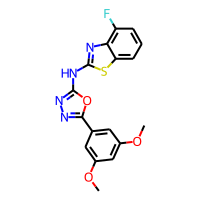
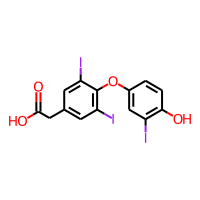
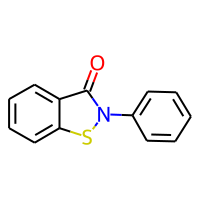
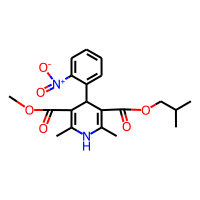
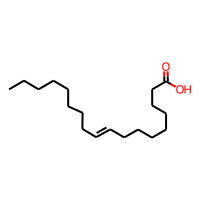

In [30]:
show(EUOS_db.sort_values(by=['ADA_ECFP6_Model'], ascending=False).head(5))

In [31]:
# ecfp6_outdf = EUOS_db.drop('ROMol', axis=1)

ADA_out_pred_csv = EUOS_db.drop('ROMol', axis=1)

In [32]:
ADA_out_pred_csv.to_csv(f'{dform}_ADA_EU_OS_predictions.csv')